**Importando as Bibliotecas**

In [ ]:
import numpy as np
np.random.seed(0)
from tensorflow.random import set_seed
set_seed(0)

import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

**Carregando os Dados** (o arquivo "actual" contém todos os 72 pacientes do estudo e seus rótulos

In [ ]:
from google.colab import files
uploaded = files.upload ()

In [ ]:
actual_df = pd.read_csv('actual.csv')
actual_df.head()

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [ ]:
actual_df['cancer'].value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

In [ ]:
actual_df.shape

(72, 2)

**Transformando os rótulos** (ALL e AML) para numérico '0' e '1'.

In [ ]:
y = actual_df.replace({'ALL':0, 'AML':1})
y = y.set_index('patient')
labels = ['ALL', 'AML']

**Carregando os conjuntos de treinamento e de teste**

In [ ]:
from google.colab import files
uploaded = files.upload ()

Saving data_set_ALL_AML_independent.csv to data_set_ALL_AML_independent.csv
Saving data_set_ALL_AML_train.csv to data_set_ALL_AML_train.csv


In [ ]:
train_df = pd.read_csv('data_set_ALL_AML_train.csv')
test_df = pd.read_csv('data_set_ALL_AML_independent.csv')

In [ ]:
print("Shape of Training Data: ", train_df.shape)
print("Shape of Testing Data: ", test_df.shape)

Shape of Training Data:  (7129, 78)
Shape of Testing Data:  (7129, 70)


**Mostra o conjunto de treinamento**

In [ ]:
train_df.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,5,call.4,6,call.5,7,call.6,8,call.7,9,call.8,10,call.9,11,call.10,12,call.11,13,call.12,14,call.13,15,call.14,16,call.15,17,call.16,18,call.17,19,call.18,20,call.19,21,call.20,22,call.21,23,call.22,24,call.23,25,call.24,26,call.25,27,call.26,34,call.27,35,call.28,36,call.29,37,call.30,38,call.31,28,call.32,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,-106,A,-138,A,-72,A,-413,A,5,A,-88,A,-165,A,-67,A,-92,A,-113,A,-107,A,-117,A,-476,A,-81,A,-44,A,17,A,-144,A,-247,A,-74,A,-120,A,-81,A,-112,A,-273,A,-20,A,7,A,-213,A,-25,A,-72,A,-4,A,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,-125,A,-85,A,-144,A,-260,A,-127,A,-105,A,-155,A,-93,A,-119,A,-147,A,-72,A,-219,A,-213,A,-150,A,-51,A,-229,A,-199,A,-90,A,-321,A,-263,A,-150,A,-233,A,-327,A,-207,A,-100,A,-252,A,-20,A,-139,A,-116,A,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,-76,A,215,A,238,A,7,A,106,A,42,A,-71,A,84,A,-31,A,-118,A,-126,A,-50,A,-18,A,-119,A,100,A,79,A,-157,A,-168,A,-11,A,-114,A,-85,A,-78,A,-76,A,-50,A,-57,A,136,A,124,A,-1,A,-125,A,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,168,A,71,A,55,A,-2,A,268,A,219,M,82,A,25,A,173,A,243,M,149,A,257,A,301,A,78,A,207,A,218,A,132,A,-24,A,-36,A,255,A,316,A,54,A,81,A,101,A,132,A,318,A,325,A,392,P,241,A,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,-230,A,-272,A,-399,A,-541,A,-210,A,-178,A,-163,A,-179,A,-233,A,-127,A,-205,A,-218,A,-403,A,-152,A,-146,A,-262,A,-151,A,-308,A,-317,A,-342,A,-418,A,-244,A,-439,A,-369,A,-377,A,-209,A,-396,A,-324,A,-191,A,-51,A,-139,A,-367,A,-188,A,-407,A


A descrição dos 7129 genes são mostradas nas linhas e os valores para cada paciente nas colunas. Há a necessidade de um pequeno ajuste.

**Removendo as colunas "call" dos conjuntos de treinamento e teste**

In [ ]:
train_to_keep=[col for col in train_df.columns if "call" not in col]
test_to_keep=[col for col in test_df.columns if "call" not in col]

X_train = train_df[train_to_keep]
X_test = test_df[test_to_keep]


**Agora podemos simplesmente transpor os dataframes de treinamento e teste para que os genes se tornem colunas (características) e os pacientes se tornem linhas.**

In [ ]:
X_train = X_train.T
X_test = X_test.T

**As primeiras 2 linhas são duplicadas para que possamos remover 'Descrição do gene' e definir 'Número de acesso do gene' como cabeçalhos de coluna.**

In [ ]:
X_train.columns = X_train.iloc[1]
X_test.columns = X_test.iloc[1]

X_train = X_train.drop(['Gene Description', 'Gene Accession Number'])
X_test = X_test.drop(['Gene Description', 'Gene Accession Number'])

**Os índices de linha de treinamento e teste não estão em ordem numérica, então é importante que os reordenemos, para que os rótulos se alinhem com os dados correspondentes.**

In [ ]:
X_train.index = X_train.index.astype(int)
X_train.sort_index(inplace=True)

X_test.index = X_test.index.astype(int)
X_test.sort_index(inplace=True)

**No final, nossos dados vão ficar assim:**

In [ ]:
print("Shape of Training data:\t", X_train.shape)
print("Shape of Testing Data:\t", X_test.shape)

Shape of Training data:	 (38, 7129)
Shape of Testing Data:	 (34, 7129)


In [ ]:
X_train.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,-41,-831,-653,-462,75,381,-118,-565,15091,7,311,-231,21,-107,165,-78,-204,29,-61,-105,-366,-41,-346,-297,-109,-13,215,797,14538,9738,...,391,-763,172,149,341,788,21210,13771,598,396,245,14476,10882,701,2762,-325,-67,346,-68,229,-14,108,28,349,61,273,384,-306,-1827,1582,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,19,-743,-239,-83,182,164,-141,-423,11038,37,134,-161,-21,-180,18,-120,-65,97,15,-49,-330,-41,-772,-259,-192,-219,116,433,615,115,...,200,51,154,418,433,736,21059,15097,563,171,-149,13686,11789,76,1567,-191,-88,290,14,194,56,303,-242,214,-28,143,231,-336,-2380,624,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,19,-1135,-962,-232,208,432,84,-501,16692,183,378,-221,67,-203,238,-124,-161,36,-23,-80,-481,-65,-620,-269,-136,104,476,1474,5669,3272,...,387,-474,180,272,591,959,24292,17378,1808,363,325,6560,5023,804,1090,-258,9,220,-58,294,95,143,-25,464,513,238,720,-204,-1772,753,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,363,-934,-577,-214,142,271,-107,-101,15763,45,268,-27,43,-52,247,-116,-208,22,-10,-74,-240,-33,-560,-261,-366,-148,155,415,4850,2293,...,317,-336,325,149,173,431,17558,13818,576,455,594,8955,9567,367,1708,-357,45,430,-35,128,42,22,-131,342,142,277,307,-320,-2022,743,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,155,-471,-490,-184,32,213,1,-260,18128,-28,118,-153,-8,-111,44,-88,-102,32,5,-18,-228,53,-348,-169,-156,-55,122,483,1284,2731,...,162,-56,279,183,259,605,18530,15619,65,122,126,8443,8512,182,1503,-78,29,159,18,71,42,44,-33,159,71,134,178,-182,-179,626,156,649,57,504,-26,250,314,14,56,-25


**Agora vamos dividir os rótulos de destino em alvos de treinamento e teste.**

In [ ]:
y_train = y['cancer'][:38]
y_test = y['cancer'][38:]

**Normalização dos dados (Características)**

Observe que o conjunto de teste deve usar uma escala idêntica ao conjunto de treinamento.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


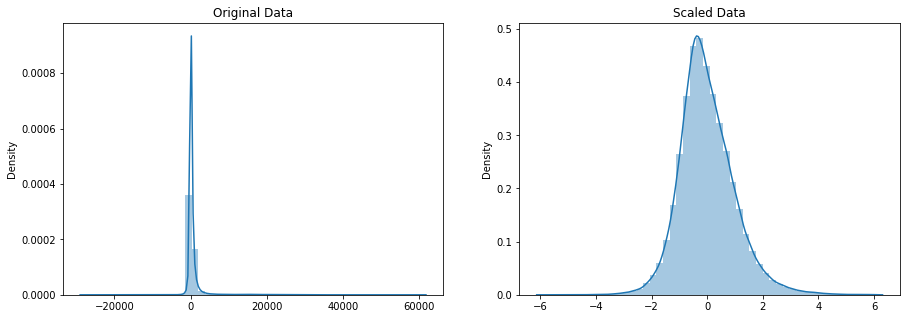

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.distplot(np.concatenate(X_train.values), ax=ax[0]).set_title('Original Data')
sns.distplot(np.concatenate(X_train_scaled), ax=ax[1]).set_title('Scaled Data')
plt.tight_layout
plt.show()

**Redução da Dimensionalidade com PCA (Principal Compoenent Analysis)**

Precisamos aplicar o mesmo PCA em conjuntos de treinamento e teste.

In [ ]:
pca = PCA(n_components = 0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(X_train_pca.shape)
print(X_test_pca.shape)

(38, 32)
(34, 32)


95% da variância é explicada por 32 componentes principais. Não podemos plotar algo em 32 dimensões, então vamos ver como o PCA se parece quando escolhemos os três componentes principais.

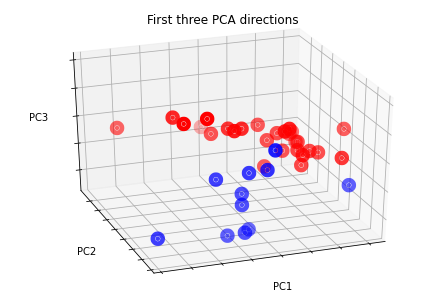

In [ ]:
pca3 = PCA(n_components = 3).fit_transform(X_train_scaled)
colors = np.where(y_train==0, 'red', 'blue')
plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(pca3[:, 0], pca3[:, 1], pca3[:, 2], c=colors, cmap=plt.cm.Paired,linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("PC1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("PC2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("PC3")
ax.w_zaxis.set_ticklabels([])
plt.show()

**A Rede Neural Artificial (RNA)**

In [ ]:
NN_model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=X_train_pca[1].shape),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
NN_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy']
)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.005,
    restore_best_weights=True,
)

In [ ]:
train_history = NN_model.fit(
    X_train_pca, y_train,
    validation_data=(X_test_pca, y_test),
    batch_size = 8,
    epochs = 50,
    callbacks=[early_stopping]
)

Epoch 1/50
5/5 [==============================] - 0s 17ms/step - loss: 0.0182 - binary_accuracy: 1.0000 - val_loss: 0.5695 - val_binary_accuracy: 0.8529
Epoch 2/50
5/5 [==============================] - 0s 10ms/step - loss: 0.0150 - binary_accuracy: 1.0000 - val_loss: 0.5688 - val_binary_accuracy: 0.8529
Epoch 3/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0130 - binary_accuracy: 1.0000 - val_loss: 0.5687 - val_binary_accuracy: 0.8529
Epoch 4/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0099 - binary_accuracy: 1.0000 - val_loss: 0.5686 - val_binary_accuracy: 0.8529
Epoch 5/50
5/5 [==============================] - 0s 9ms/step - loss: 0.0084 - binary_accuracy: 1.0000 - val_loss: 0.5687 - val_binary_accuracy: 0.8529
Epoch 6/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0076 - binary_accuracy: 1.0000 - val_loss: 0.5688 - val_binary_accuracy: 0.8529


In [ ]:
pred = NN_model.predict_classes(X_test_pca)
print('Neural Network accuracy: ', round(accuracy_score(y_test, pred), 3))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Neural Network accuracy:  0.853


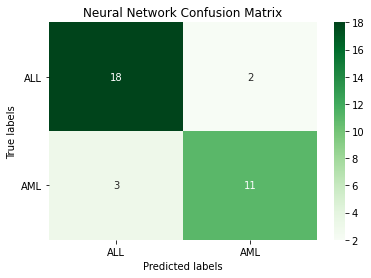

In [ ]:
cm_nn = confusion_matrix(y_test, pred)

ax = plt.subplot()
sns.heatmap(cm_nn, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Neural Network Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);